## Sentiment Analysis With Basic Neural Network

Using imdb movie reviews dataset, we will train a basic ANN to predict the sentiment of Warren Buffett's annual 'Letter to Shareholders'.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import regex as re
from sklearn.model_selection import train_test_split

# Load IMDB dataset
dataset = tfds.load('imdb_reviews', split='train')
dataframe = tfds.as_dataframe(dataset)

# Decode each text and put into pandas df
imdb_df = pd.DataFrame()
regexes = (("<", ""), ("br", "", ), ("/>", ""), ("  ", " "))
reviews = []
for text in dataframe['text']:
    text = text.decode()
    for reg in regexes:
        text = re.sub(reg[0], reg[1], text)
    reviews.append(text)
imdb_df['text'] = reviews
imdb_df['label'] = dataframe['label']

# Split data into training and validation
train_X, test_X, train_y, test_y = train_test_split(imdb_df['text'].values, imdb_df['label'].values, test_size=0.2)

2023-08-14 18:50:48.919353: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 18:50:49.011878: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 18:50:49.012699: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 18:50:49.947689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ben/.pyenv/versions/3.10.6/envs/BuffettLetters/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-

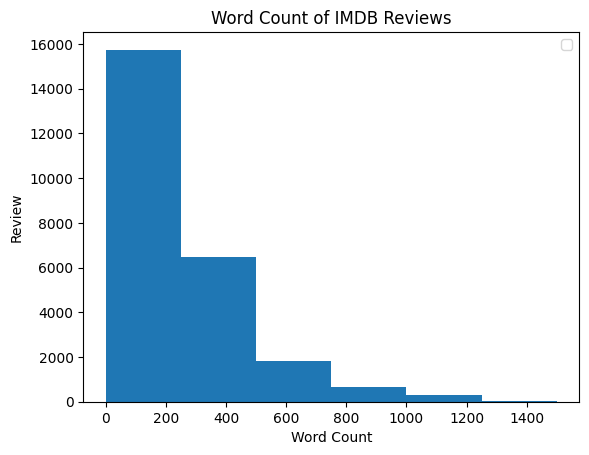

In [2]:
import matplotlib.pyplot as plt
import nltk

# Tokenize each review
tokenized_reviews = []   
for text in imdb_df['text']:
    text = nltk.word_tokenize(text)
    tokenized_reviews.append(text)

# Add to new df
df_tok = pd.DataFrame()
df_tok['text'] = tokenized_reviews

# Plot hist of word counts
fig = plt.figure()
ax = fig.add_subplot()
ax.hist([len(text) for text in df_tok['text']], [0, 250, 500, 750, 1000, 1250, 1500])
ax.set_title('Word Count of IMDB Reviews')
ax.set_xlabel('Word Count')
ax.set_ylabel('Review')
ax.legend()

IMDB reviews are much shorter than the letters we are trying to predict the sentiment of. Therefore, we will train the ANN to predict the sentiment of individual sentences and then use the average sentiment of all sentences in a letter to predict the overall sentiment of the letter.

In [3]:
from keras.layers import TextVectorization

# Parameters for vocab size and number of words in a sequence
vocab_size = 10000
seq_len = 250  # Rough average of word count

# Use TextVectorization to turn strings into vectors of integers
vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size, 
    output_mode='int',
    output_sequence_length=seq_len)

# Build vocabulary
all_reviews = imdb_df['text'].values
vectorize_layer.adapt(all_reviews)

In [4]:
# Build model
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

# Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

# Train model
model.fit(train_X, train_y, epochs=30)
history = model.history

Epoch 1/30
625/625 [==============================] - 3s 4ms/step - loss: 0.5757 - accuracy: 0.7427
Epoch 2/30
625/625 [==============================] - 2s 3ms/step - loss: 0.3136 - accuracy: 0.8790
Epoch 3/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2406 - accuracy: 0.9079
Epoch 4/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2005 - accuracy: 0.9246
Epoch 5/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1694 - accuracy: 0.9377
Epoch 6/30
625/625 [==============================] - 2s 4ms/step - loss: 0.1469 - accuracy: 0.9488
Epoch 7/30
625/625 [==============================] - 2s 4ms/step - loss: 0.1267 - accuracy: 0.9581
Epoch 8/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1101 - accuracy: 0.9646
Epoch 9/30
625/625 [==============================] - 2s 3ms/step - loss: 0.0945 - accuracy: 0.9714
Epoch 10/30
625/625 [==============================] - 2s 3ms/step - loss: 0.0825 - accuracy: 0.9759

Text(0, 0.5, 'Loss')

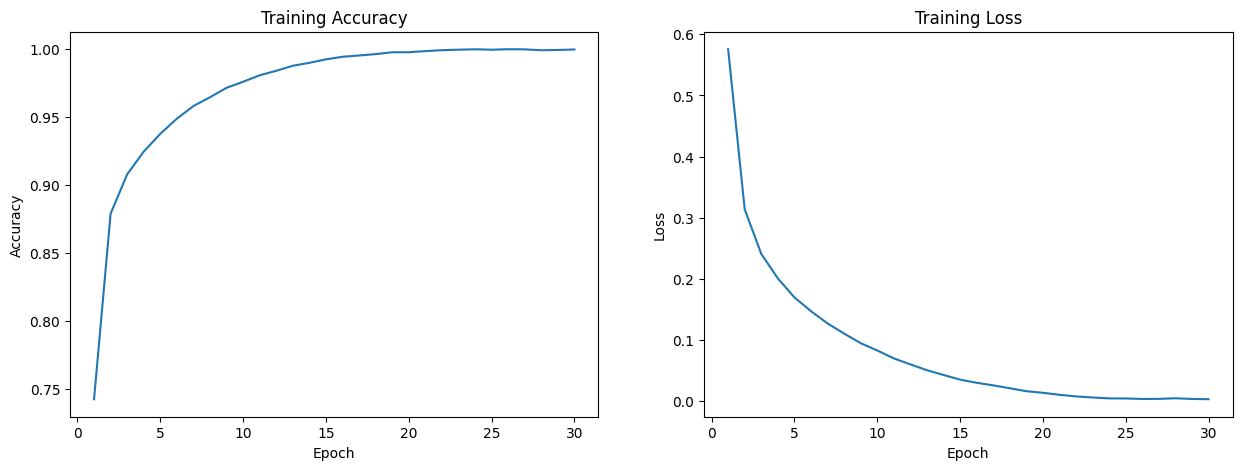

In [5]:
# Graph training accuracy and loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
epochs = [i for i in range(1, len(history.history['loss'])+1)]
axes[0].plot(epochs, history.history['accuracy'], label='traning accuracy')
axes[0].set_title('Training Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[1].plot(epochs, history.history['loss'], label='loss')
axes[1].set_title('Training Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

In [7]:
# Load buffett letters
import nltk
import re

letters = []
with open('data/letters.txt', 'r', encoding='utf8') as file:
    for count, line in enumerate(file):

        # Split letter into list of sentences and remove figures
        sents = nltk.sent_tokenize(line)
        for sent in sents:
            if (re.search("\.\.\.\.\.", sent)) is not None:  # Figures indicated by long elipses
                del sents[sents.index(sent)]
            if (re.search("\. \. \. \. ", sent)) is not None:  # 21st letter has spaces inbetween periods
                del sents[sents.index(sent)]
        letters.append(sents)

In [19]:
# Read sp500 data, reverse indices, and start at 1977
sp500 = pd.read_csv('data/sp500.csv')
sp500 = sp500.iloc[::-1]
sp500 = sp500[sp500['year'] >= 1978]
sp500 = sp500.reset_index()

# Load letters and SP500 performance into df
df = pd.DataFrame()
df['Year'] = [i for i in range(1977, 2022)]
df['Letter'] = letters
df['SP500 Year After'] = sp500['performance']
df.head()

,Year,Letter,SP500 Year After
0,1977,[To the Stockholders of Berkshire Hathaway Inc...,6.56
1,1978,[To the Shareholders of Berkshire Hathaway Inc...,18.44
2,1979,[To the Shareholders of Berkshire Hathaway Inc...,32.42
3,1980,[To the Shareholders of Berkshire Hathaway Inc...,-4.91
4,1981,[To the Shareholders of Berkshire Hathaway Inc...,21.55


In [ ]:
# Predict sentiment of each sentence in each letter
sentiments = []
for letter in letters:
    avg_sent = []
    for sent in letter:
        sent = [sent]
        avg_sent.append(model.predict(sent))
    avg_sent = sum(avg_sent) / len(avg_sent)
    sentiments.append(avg_sent)

# Add sentiment to df
df['Sentiment'] = sentiments

# Save df as pickle
df.to_pickle('data/ann_pred.pkl')

No need to predict every time, it takes over 40 minutes. Results saved as ann_pred.pkl.

In [40]:
# Load df from pickle
df = pd.read_pickle('data/ann_pred.pkl')

# Extract value from sentiment column
df['Sentiment'] = df['Sentiment'].apply(lambda x: float(x[0][0]))


In [41]:
# Scale SP500 and Sentiment columns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['SP500 Year After'] = scaler.fit_transform(df[['SP500 Year After']])
df['Sentiment'] = scaler.fit_transform(df[['Sentiment']])
df.head()

,Year,Letter,SP500 Year After,Sentiment
0,1977,[To the Stockholders of Berkshire Hathaway Inc...,0.584071,0.128410
1,1978,[To the Shareholders of Berkshire Hathaway Inc...,0.743363,0.436595
2,1979,[To the Shareholders of Berkshire Hathaway Inc...,0.930813,0.285983
3,1980,[To the Shareholders of Berkshire Hathaway Inc...,0.430276,0.075540
4,1981,[To the Shareholders of Berkshire Hathaway Inc...,0.785063,0.127439


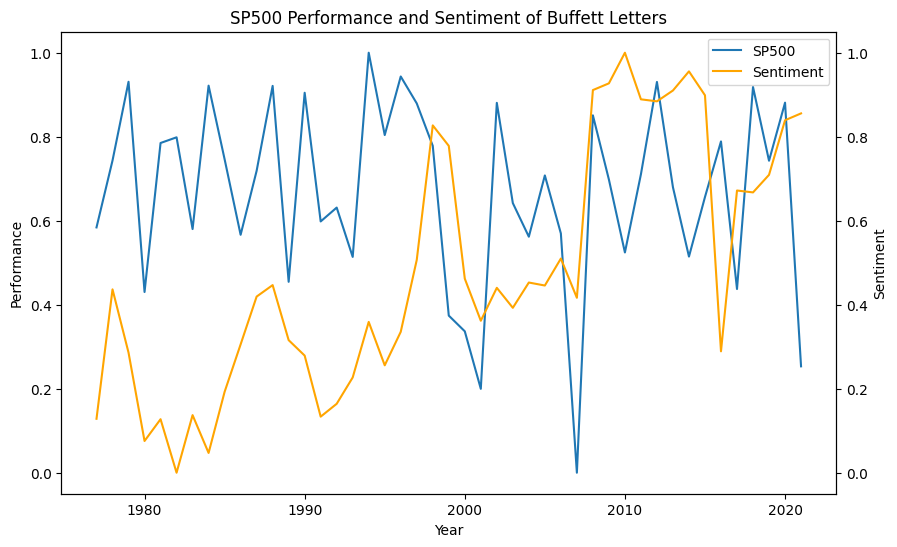

In [42]:
# Plot SP500 performance and sentiment
fig, ax = plt.subplots()
fig.set_figheight(6), fig.set_figwidth(10)
ax.plot(df['Year'], df['SP500 Year After'], label='SP500')
ax.set_title('SP500 Performance and Sentiment of Buffett Letters')
ax.set_xlabel('Year')
ax.set_ylabel('Performance')
ax2 = ax.twinx()
ax2.plot(df['Year'], df['Sentiment'], color='orange', label='Sentiment')
ax2.set_ylabel('Sentiment')

# Add legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

It's not clear there is any correlation between predicted sentiment and SP500 performance the year after a letter was written. Sentiments are often more positive after the late 1990's, not tied to market performance at all, so it's not clear that the basic neural network is learning anything useful.

## Sentiment Analysis With Recurrent Neural Network

It was not expected for a simple neural network to have much success with sentiment classification, so here we try a recurrent neural network with long short-term memory cells. We also increased the size of the fully connected layer to 32 neurons.

In [ ]:
# Build model
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),  # bidirectional LSTM
    tf.keras.layers.Dense(32, activation='relu'),  # adding more neurons to dense layer because of poor accuracy
    tf.keras.layers.Dense(1, activation='sigmoid')])

# Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

# Train model
model.fit(train_X, train_y, epochs=20)
history = model.history

Text(0, 0.5, 'Loss')

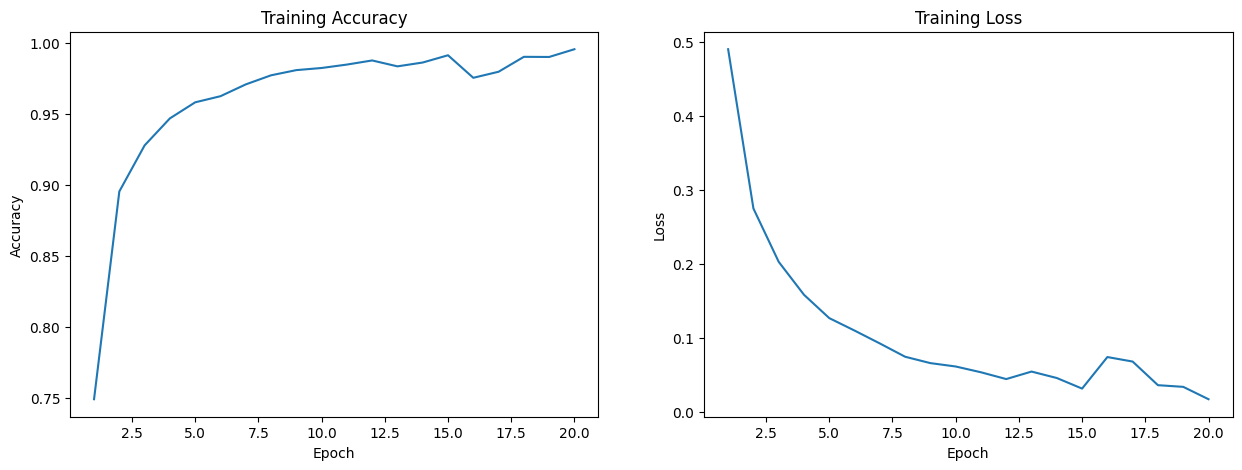

In [13]:
# Graph training accuracy and loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
epochs = [i for i in range(1, len(history.history['loss'])+1)]
axes[0].plot(epochs, history.history['accuracy'], label='traning accuracy')
axes[0].set_title('Training Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[1].plot(epochs, history.history['loss'], label='loss')
axes[1].set_title('Training Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

Curves not quite as smooth as they were for the ANN but accuracy is generally the same.

In [ ]:
# Save model (training took about 8 minutes on CPU)
model.save('models/lstm_model.tf', save_format='tf')

In [ ]:
# Load model and predict sentiment of each sentence in each letter
model = tf.keras.models.load_model('models/lstm_model.tf')

# Predict sentiment of each sentence in each letter
sentiments = []
for letter in letters:
    avg_sent = []
    for sent in letter:
        sent = [sent]
        avg_sent.append(model.predict(sent, ))
    avg_sent = sum(avg_sent) / len(avg_sent)
    sentiments.append(avg_sent)

# Add sentiment to df
df['Sentiment'] = sentiments

# Save df as pickle
df.to_pickle('data/rnn_pred.pkl')

In [20]:
# Scale SP500 and Sentiment columns
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Load df from pickle
df = pd.read_pickle('data/rnn_pred.pkl')

scaler = MinMaxScaler()
df['SP500 Year After'] = scaler.fit_transform(df[['SP500 Year After']])
df['Sentiment'] = scaler.fit_transform(df[['Sentiment']])
df.head()

,Year,Letter,SP500 Year After,Sentiment
0,1977,[To the Stockholders of Berkshire Hathaway Inc...,0.584071,0.857472
1,1978,[To the Shareholders of Berkshire Hathaway Inc...,0.743363,1.000000
2,1979,[To the Shareholders of Berkshire Hathaway Inc...,0.930813,0.896632
3,1980,[To the Shareholders of Berkshire Hathaway Inc...,0.430276,0.789563
4,1981,[To the Shareholders of Berkshire Hathaway Inc...,0.785063,0.832046


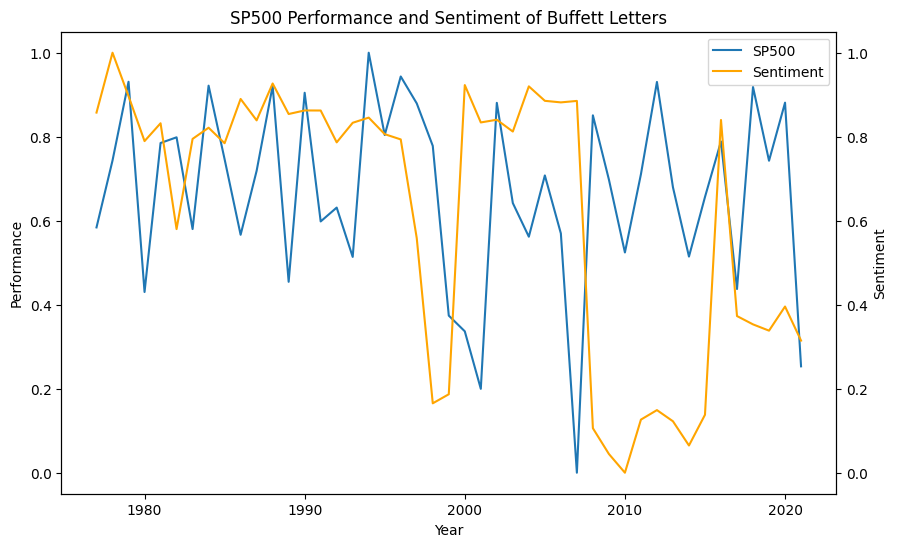

In [21]:
# Plot SP500 performance and sentiment
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_figheight(6), fig.set_figwidth(10)
ax.plot(df['Year'], df['SP500 Year After'], label='SP500')
ax.set_title('SP500 Performance and Sentiment of Buffett Letters')
ax.set_xlabel('Year')
ax.set_ylabel('Performance')
ax2 = ax.twinx()
ax2.plot(df['Year'], df['Sentiment'], color='orange', label='Sentiment')
ax2.set_ylabel('Sentiment')

# Add legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

Still no clear correlation between the performance of the SP500 and predicted sentiment of a letter. For some reason sentiment scales much better with the SP500 than previously, but it's still not clear that the RNN is learning anything useful. There are some drops and increases that appear to mirror each other, such as the first several years from 1977-1985. They do not line up exactly, but after sentiment makes a move, the SP500 seems to follow. 1985-1995 do not follow this trend very well. We then see a large drop and large increase around the year 2000 that do match up with the SP500 very well, but again there is a delay in sentiment vs. the market. We then see a big drop in the market around 2008, with sentiment following the year after, then sentiment remains very low until 2015-2016 when it jumps up again the same year as the market then remains uncorrelated.

## Conclusions

After training two different neural networks with IMDB movie reviews, we saw some potential merit in predicting the sentiment of Warren Buffett's annual letters to shareholders and comparing it to the SP500, specifically with the RNN. However, the correlation is not consistent year to year and there is often a delay in sentiment vs. the market, so the relationships we do see may be caused by nothing in particular.

Flaws in our approach include the training data for our models. The IMDB movie reviews are very short, a few sentences, and use a much more informal writing style than Warren Buffett for his letters, so the model may have a hard time in predicting the sentiment of the letters even if we trained a model well. Movie reviews also try to capture sentiment very quickly in a few sentences, leading to words and phrases than easily show you what the reviewer thought of the movie. Buffett's letters are no doubt much dryer and explanatory and it probably takes understanding of his figures and performance of his companies to truly grasp how the trends of the market, something the model again will not be able to do.

Predicting the sentiment of each sentence and then taking the average of all sentiments may also be a poor approach. It may be more useful to look at the proporition of sentiments, perhaps ignoring neutral sentences that would move the average to a neutral sentiment. Preferably we would have many more letters written by Buffett so that we could train models on his writing specifically - but there are only 45 letters and they differ greatly in length throughout the years. We could also try text more similar to Buffett's writing, such as other shareholder letters, other texts written by Buffett, or articles that discuss market performance.

More complex models could be built or pre-trained models with fine-tuning could be used.